explore data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df_train = pd.read_csv('../input/train.csv.zip',compression='zip')
df_per_train = pd.read_csv('../input/periods_train.csv.zip',compression='zip')


In [13]:
df_test = pd.read_csv('../input/test.csv.zip',compression='zip')

`train_active.csv`: Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data minus deal_probability, image, and image_top_1.

train_active sampling .... very large (2.3G)

In [48]:
df_active = pd.read_csv('../input/train_active.csv.zip',compression='zip',nrows=10000)

In [51]:
df_active.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type'],
      dtype='object')

In [60]:
len(df_active.item_id[df_active.item_id.duplicated()]) ## duplicated item_id

81

size 

In [47]:
df_train.shape

(1503424, 18)

In [10]:
df_per_train.shape

(16687412, 4)

In [15]:
df_test.shape

(508438, 17)

In [12]:
df_train.head().T

,0,1,2,3,4
item_id,b912c3c6a6ad,2dac0150717d,ba83aefab5dc,02996f1dd2ea,7c90be56d2ab
user_id,e00f8ff2eaf9,39aeb48f0017,91e2f88dd6e3,bf5cccea572d,ef50846afc0b
region,Свердловская область,Самарская область,Ростовская область,Татарстан,Волгоградская область
city,Екатеринбург,Самара,Ростов-на-Дону,Набережные Челны,Волгоград
parent_category_name,Личные вещи,Для дома и дачи,Бытовая электроника,Личные вещи,Транспорт
category_name,Товары для детей и игрушки,Мебель и интерьер,Аудио и видео,Товары для детей и игрушки,Автомобили
param_1,Постельные принадлежности,Другое,"Видео, DVD и Blu-ray плееры",Автомобильные кресла,С пробегом
param_2,NaN,NaN,NaN,NaN,ВАЗ (LADA)
param_3,NaN,NaN,NaN,NaN,2110
title,Кокоби(кокон для сна),Стойка для Одежды,Philips bluray,Автокресло,"ВАЗ 2110, 2003"


- number of unique uid

In [16]:
df_train.user_id.nunique() # 771,769 out of 1,503,424 

771769

In [18]:
df_test.user_id.nunique() # 306,069 

306069

In [28]:
uid_in_trn_test = np.intersect1d(df_test.user_id,df_train.user_id) # 67,929

In [31]:
pd.Series(uid_in_trn_test).nunique()

67929

In [32]:
test_uid = df_test.user_id.unique()
train_uid = df_train.user_id.unique()

In [36]:
771769- 67929

703840

In [37]:
306069 - 67929

238140

- number of unique itemid

In [40]:
train_itemid = df_train.item_id.unique()
test_itemid = df_test.item_id.unique()

In [41]:
train_itemid.size  # equal to # of df_train

1503424

In [42]:
test_itemid.size

508438

In [43]:
itmid_in_trn_test = np.intersect1d(train_itemid,test_itemid)

In [61]:
itmid_in_trn_test.size

0

**itemid** is pkey in train/test sets

In [67]:
def get_df_matrix_mappings(df, row_name, col_name):
    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid


    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid


    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid

In [83]:
import scipy.sparse as sp

In [76]:
df_uidx_iidx = pd.DataFrame()
df_uidx_iidx['uidx']= df_train.user_id.map(rid_to_idx)
df_uidx_iidx['iidx'] = iid_idx = df_train.item_id.map(cid_to_idx)


In [157]:
df_train[['user_id','item_id']].drop_duplicates().shape # no duplicated u-i combiniation

(1503424, 2)

In [70]:
rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = get_df_matrix_mappings(df_train,'user_id','item_id')

In [94]:
I = df_uidx_iidx.uidx.as_matrix()
J = df_uidx_iidx.iidx.as_matrix()
V = np.ones(df_uidx_iidx.shape[0])

ui_sp = sp.coo_matrix((V,(I,J)),dtype='uint8')

In [164]:
ui_sp.shape

(771769, 1503424)

In [207]:
# plt.spy(ui_sp) ## misleading

In [172]:
ui_csr = ui_sp.tocsr()

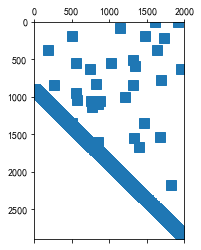

In [208]:
plt.spy(ui_csr[100:3000,1000:3000])

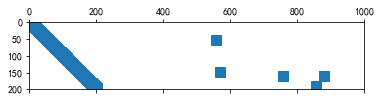

In [201]:
plt.spy(ui_csr[1000:1200,1000:2000])

In [246]:
sum_iid_by_user = np.array(ui_csr.sum(axis=1).flatten())[0]
pd.Series(sum_iid_by_user).value_counts()
# (sum_iid_by_user > 1).sum()
# ui_csr.multiply()

1      531750
2      116739
3       47878
4       24779
5       14792
6        9300
7        6427
8        4374
9        3202
10       2343
11       1749
12       1379
13       1039
14        821
15        666
16        593
17        456
18        370
19        314
20        273
22        216
21        211
23        155
24        153
25        144
26        123
27        113
28         97
29         91
30         80
        ...  
636         1
123         1
122         1
119         1
492         1
112         1
172         1
174         1
225         1
175         1
224         1
223         1
221         1
220         1
219         1
217         1
209         1
207         1
206         1
203         1
196         1
190         1
189         1
188         1
187         1
695         1
179         1
177         1
176         1
512         1
Length: 237, dtype: int64

In [247]:
pd.Series(sum_iid_by_user).value_counts(normalize=True)

1      0.689002
2      0.151262
3      0.062037
4      0.032107
5      0.019166
6      0.012050
7      0.008328
8      0.005667
9      0.004149
10     0.003036
11     0.002266
12     0.001787
13     0.001346
14     0.001064
15     0.000863
16     0.000768
17     0.000591
18     0.000479
19     0.000407
20     0.000354
22     0.000280
21     0.000273
23     0.000201
24     0.000198
25     0.000187
26     0.000159
27     0.000146
28     0.000126
29     0.000118
30     0.000104
         ...   
636    0.000001
123    0.000001
122    0.000001
119    0.000001
492    0.000001
112    0.000001
172    0.000001
174    0.000001
225    0.000001
175    0.000001
224    0.000001
223    0.000001
221    0.000001
220    0.000001
219    0.000001
217    0.000001
209    0.000001
207    0.000001
206    0.000001
203    0.000001
196    0.000001
190    0.000001
189    0.000001
188    0.000001
187    0.000001
695    0.000001
179    0.000001
177    0.000001
176    0.000001
512    0.000001
Length: 237, dtype: floa

most of user see only 1 itemid (68.9%) in training sets

In [253]:
ui_csr[0:10,].sum(axis=1) ## 

matrix([[1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [6],
        [9],
        [5]], dtype=uint32)

In [269]:
df_train.deal_probability.head(20)

0     0.12789
1     0.00000
2     0.43177
3     0.80323
4     0.20797
5     0.80323
6     0.00000
7     0.80323
8     0.00000
9     0.00000
10    0.58853
11    0.00000
12    0.13858
13    0.00000
14    0.00000
15    0.00000
16    0.32100
17    0.00000
18    0.00000
19    0.10342
Name: deal_probability, dtype: float64

In [268]:
deal_seenitem_byuser = pd.DataFrame()
deal_seenitem_byuser['num_seen_items_train'] = sum_iid_by_user
deal_seenitem_byuser['deal_prob']= df_train.deal_probability
deal_seenitem_byuser['price'] = df_train.price
deal_seenitem_byuser['item_seq_number'] = df_train.item_seq_number
deal_seenitem_byuser.corr() ##　no correlation 

,num_seen_items_train,deal_prob,price,item_seq_number
num_seen_items_train,1.000000,0.001156,0.000759,0.006737
deal_prob,0.001156,1.000000,-0.012028,-0.035603
price,0.000759,-0.012028,1.000000,0.079743
item_seq_number,0.006737,-0.035603,0.079743,1.000000


In [265]:
df_train.dtypes

item_id                  object
user_id                  object
region                   object
city                     object
parent_category_name     object
category_name            object
param_1                  object
param_2                  object
param_3                  object
title                    object
description              object
price                   float64
item_seq_number           int64
activation_date          object
user_type                object
image                    object
image_top_1             float64
deal_probability        float64
dtype: object

In [267]:
df_train.item_seq_number ##  Ad sequential number for user

0            2
1           19
2            9
3          286
4            3
5            9
6          125
7           61
8           85
9          136
10           6
11           4
12          15
13          47
14           6
15          86
16         201
17           9
18           4
19           5
20         461
21          33
22          12
23          59
24         310
25         309
26          59
27           8
28          12
29          20
          ... 
1503394      5
1503395     41
1503396     32
1503397     36
1503398      8
1503399      2
1503400     12
1503401      6
1503402     61
1503403     23
1503404      1
1503405     39
1503406    259
1503407     33
1503408     24
1503409    145
1503410     26
1503411     17
1503412     78
1503413     77
1503414      8
1503415      6
1503416     89
1503417     13
1503418     10
1503419      7
1503420      1
1503421     50
1503422     33
1503423     18
Name: item_seq_number, Length: 1503424, dtype: int64

# item_seq_num ???

In [271]:
item_seq_num = df_train.item_seq_number

In [273]:
item_seq_num.nunique()

28232

In [277]:
item_seq_num.value_counts()

1         90378
2         58481
3         48047
4         42074
5         37679
6         34629
7         32102
8         29905
9         28221
10        26899
11        25274
12        23876
13        22784
14        21655
15        20825
16        19819
17        18985
18        18305
19        17456
20        16761
21        16225
22        15619
23        15018
24        14574
25        14120
26        13642
27        13242
28        12856
29        12300
30        12180
          ...  
23128         1
19034         1
20431         1
72304         1
54857         1
52810         1
13909         1
9815          1
20058         1
28254         1
53833         1
33347         1
71280         1
120424        1
14933         1
8790          1
10839         1
21080         1
19035         1
72305         1
76407         1
54856         1
52811         1
18382         1
13908         1
9814          1
20059         1
26206         1
101987        1
48653         1
Name: item_seq_number, L

In [280]:
rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = get_df_matrix_mappings(df_train,'user_id','item_seq_number')

In [281]:
df_uidx_iidx = pd.DataFrame()
df_uidx_iidx['uidx']= df_train.user_id.map(rid_to_idx)
df_uidx_iidx['iidx'] = iid_idx = df_train.item_seq_number.map(cid_to_idx)


In [283]:
I = df_uidx_iidx.uidx.as_matrix()
J = df_uidx_iidx.iidx.as_matrix()
V = np.ones(df_uidx_iidx.shape[0])

ui_coo = sp.coo_matrix((V,(I,J)),dtype='uint8')

In [284]:
ui_csr = ui_coo.tocsr()

In [287]:
ui_csr

<771769x28232 sparse matrix of type '<class 'numpy.uint8'>'
	with 1503424 stored elements in Compressed Sparse Row format>

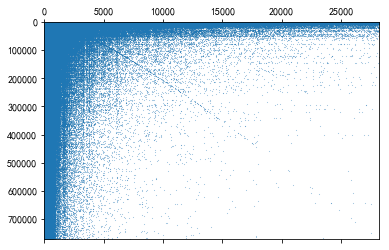

In [296]:
plt.spy(ui_csr,markersize=0.1,aspect='auto')

In [308]:
print('first 100,000 row sum:',ui_csr[:100000,:].sum())
print('last 100,000 rows sum:',ui_csr[-100000:,:].sum())

first 100,000 row sum: 438313
last 100,000 rows sum: 104459


In [315]:
print('first 100,000 rows prob:{:.2f}'.format(df_train.deal_probability[:100000].sum()))
print('slice 100,000 rows prob:{:.2f}'.format(df_train.deal_probability[200000:300000].sum()))
print('last 100,000 rows prob:{:.2f}'.format(df_train.deal_probability[-100000:].sum()))

first 100,000 rows prob:13982.30
slice 100,000 rows prob:13934.69
last 100,000 rows prob:13859.95


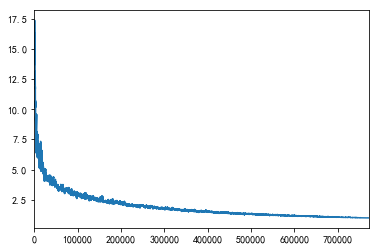

In [328]:
pd.Series(np.array(ui_csr.sum(axis=1)).flatten()).rolling(1000).mean().plot()

In [332]:
df_train[['user_id','item_seq_number']].drop_duplicates().shape

(1503424, 2)

smaller uidx --> see more seq_item_id 

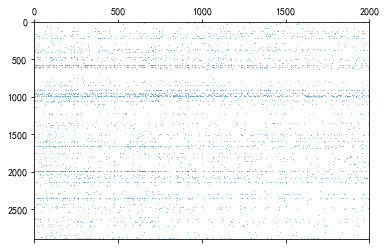

In [297]:
plt.spy(ui_csr[100:3000,1000:3000],markersize=0.1,aspect='auto')

In [337]:
np.array(ui_csr.sum(axis=1)).flatten().max()

1080

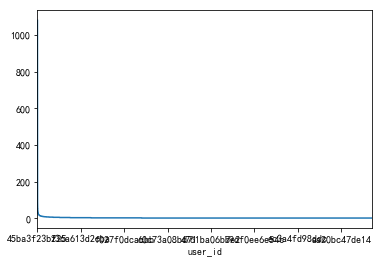

In [338]:
df_train.groupby('user_id').size().sort_values(ascending=False).plot() ## max same as 1080

In [339]:
df_train.groupby('user_id').size().sort_values(ascending=False).head()

user_id
45ba3f23bf25    1080
ee74bccca74f     980
60dfed1efb6e     907
b239811ad530     840
abcdd1ca1a5c     807
dtype: int64

In [341]:
mask = df_train.user_id=='45ba3f23bf25'
df_train[mask]

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
1333,1c2963f01ede,45ba3f23bf25,Иркутская область,Саянск,Бытовая электроника,Товары для компьютера,Клавиатуры и мыши,NaN,NaN,23.03/ Мышь оптическая проводная в блистере,Телефон магазина в объявлении. Уточняйте нали...,390.0,72090,2017-03-23,Shop,573ff2118089e3f5af17dd0b90200851afbbf3ba04e23f...,2826.0,0.00000
4062,d3e7c9a53892,45ba3f23bf25,Иркутская область,Иркутск,Бытовая электроника,Планшеты и электронные книги,Планшеты,NaN,NaN,17.03/ Планшет Samsung SM-T110 8Gb,— тыловая камера 2 Мпикс,4499.0,71290,2017-03-17,Shop,a9b164750803ecabfb744b03faab1402ebc756b77c36fd...,2877.0,0.00000
5514,b787659b066d,45ba3f23bf25,Иркутская область,Иркутск,Бытовая электроника,Телефоны,LG,NaN,NaN,20.03/ LG-p713,"— смартфон, Android 4.4/\n— экран 4.3"", разреш...",2499.0,71448,2017-03-20,Shop,fadddb730c0468f1ee596242a232b172ffd876e97cfb7b...,2942.0,0.00000
5576,7ea6632deae5,45ba3f23bf25,Иркутская область,Саянск,Бытовая электроника,Телефоны,Alcatel,NaN,NaN,16.03/ Aлкatel 4007дотходитсзу,"— смартфон, Android 2.3/\n— поддержка двух SIM...",999.0,71140,2017-03-16,Shop,c77cf41b66e9958fa4054d113ccd7e2bb781cef3f9f730...,2007.0,0.00000
6780,c03aed0f335b,45ba3f23bf25,Иркутская область,Иркутск,Бытовая электроника,Телефоны,BQ,NaN,NaN,22.03/ bqbqm-1831,— телефон/\n— поддержка двух SIM-карт/\n— экра...,899.0,71914,2017-03-22,Shop,3b0faf89ea060f3ab4d96c5c1cbbb1ea894f1ead988337...,2009.0,0.12754
7396,db71089906d0,45ba3f23bf25,Иркутская область,Иркутск,Бытовая электроника,Аудио и видео,"Акустика, колонки, сабвуферы",NaN,NaN,"23.03/ Колонка игрушка ""Миньон""",Каждый день сотни новых товаров в нашем магази...,799.0,72118,2017-03-23,Shop,821649244a931f4537a97ed685637ac09226934a5a608e...,3031.0,0.00000
8830,ec147d90dffa,45ba3f23bf25,Иркутская область,Братск,Бытовая электроника,Телефоны,Другие марки,NaN,NaN,23.03/ Jinga ф100,— телефон/\n— поддержка двух SIM-карт/\n— экра...,999.0,72000,2017-03-22,Shop,a24f648f2d8d98d06a32b3c79a61468f677e1eabe6d05d...,2916.0,0.00000
9286,85a4977c673d,45ba3f23bf25,Иркутская область,Зима,Бытовая электроника,Телефоны,Sony,NaN,NaN,27.03/ Sony D5503,"(нет заглушки ЗУ и кнопки громкости, неиправн...",5899.0,72559,2017-03-27,Shop,8632e75cd3a1ce08816d1f6ce953310d228a4bc88257cc...,2944.0,0.00000
9378,247be24cea59,45ba3f23bf25,Иркутская область,Братск,Бытовая электроника,Телефоны,Lenovo,NaN,NaN,28.03/ LenovoS860,"— смартфон, Android 4.2/\n— поддержка двух SIM...",4899.0,72835,2017-03-28,Shop,a2fd0f79bf88e903c1c42ccdb7d03aeb68ea9709d4c2a0...,760.0,0.00000
10031,bec69fc5c75d,45ba3f23bf25,Иркутская область,Иркутск,Бытовая электроника,Телефоны,Micromax,NaN,NaN,27.03/ MicromaxD320,"— смартфон, Android 4.4/\n— поддержка двух SIM...",2899.0,72532,2017-03-27,Shop,d3b0e14054706e07bd7ff5498f0daa5524d66c6d48ee55...,2931.0,0.00000


In [353]:
df_train[mask].user_type.price

array(['Shop'], dtype=object)

In [356]:
df_train.groupby('item_seq_number').size().sort_values(ascending=False)

item_seq_number
1        90378
2        58481
3        48047
4        42074
5        37679
6        34629
7        32102
8        29905
9        28221
10       26899
11       25274
12       23876
13       22784
14       21655
15       20825
16       19819
17       18985
18       18305
19       17456
20       16761
21       16225
22       15619
23       15018
24       14574
25       14120
26       13642
27       13242
28       12856
29       12300
30       12180
         ...  
31275        1
31276        1
31277        1
31278        1
31252        1
31251        1
31250        1
31249        1
31222        1
31223        1
31225        1
31226        1
31227        1
31228        1
31229        1
31231        1
31232        1
31235        1
31236        1
31237        1
31238        1
31239        1
31240        1
31241        1
31242        1
31244        1
31245        1
31246        1
31248        1
18211        1
Length: 28232, dtype: int64